# Imports

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
import random

# Net Class

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output classes for MNIST digits

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

    def predict(self, x):
        logits = self.forward(x)
        return torch.argmax(logits, dim=1)

    def predict_proba(self, x):
        logits = self.forward(x)
        return torch.softmax(logits, dim=1)

# Delegation Mech. Class

In [36]:
class DelegationMechanism:
    def __init__(self, batch_size, window_size=None):
        self.delegations = {}  # key: delegate_from (id), value: delegate_to (id)
        self.t = 0
        self.window_size = window_size
        self.batch_size = batch_size

    def delegate(self, from_id, to_id):
        # cycles are impossible with this mechanism, so we don't need to check for them
        self.delegations[from_id] = to_id

    def wilson_score_interval(self, point_wise_accuracies, confidence=0.99999):
        ups = sum(point_wise_accuracies)
        downs = len(point_wise_accuracies) - ups
        n = len(point_wise_accuracies)

        # use the specified confidence value to calculate the z-score
        z = stats.norm.ppf(1 - (1 - confidence) / 2)
        p = ups / n

        left = p + 1 / (2 * n) * z * z
        right = z * np.sqrt(p * (1 - p) / n + z * z / (4 * n * n))
        under = 1 + 1 / n * z * z

        return ((left - right) / under, (left + right) / under)

    def ucb(self, voter, t, c=3.0):
        """
        Calculate upper confidence bound of the bandit arm corresponding to voting directly. Loosely speaking, if this
        is high enough the voter will vote directly.
        point_wise_accuracies is the number of samples this voter has taken, i.e. n_i in UCB terms
        t is the total number of samples taken by any agent, i.e. N in UCB terms

        :param t: number of time steps passed
        :param c: exploration term; higher means more exploration/higher chance of voting directly (?)
        """
        if self.window_size is None:
            point_wise_accuracies = (
                voter.accuracy
            )  # one value per sample that this voter has predicted upon
            t_window = t  # total number of possible data points within the window
            mean = np.mean(point_wise_accuracies)  # mean accuracy/reward of arm pulls
        else:
            # # get accuracies from the most recent batches, if within the window
            # sorted(voter.batch_accuracies_dict, reverse=True)
            # batch_number = t // self.batch_size
            # point_wise_accuracies = []

            # for batch in range(batch_number - self.window_size, batch_number + 1):
            #     if batch in voter.batch_accuracies_dict:
            #         point_wise_accuracies.append(voter.batch_accuracies_dict[batch])

            # # TODO: Unclear what to do in this case when the voter has not voted recently. Maybe go even higher?
            # if len(point_wise_accuracies) == 0:
            #     # point_wise_accuracies = [0]
            #     mean = 0
            # else:
            #     mean = np.mean(
            #         point_wise_accuracies
            #     )  # mean accuracy/reward of arm pulls

            # t_window = (
            #     self.window_size * self.batch_size
            # )  # total number of possible data points within the window

            # get the most recent window_size predictions and take the mean
            if len(voter.accuracy) < self.window_size:
                mean = np.mean(voter.accuracy)
            else:
                mean = np.mean(voter.accuracy[-self.window_size :])

        n_t = len(voter.accuracy)  # number of arm pulls the voter has taken

        fudge_factor = 1e-8

        ucb = mean + np.sqrt(c * np.log(t) / (n_t + fudge_factor))
        # ucb = mean + np.sqrt(c * np.log(t_window) / (n_t + fudge_factor))

        return ucb

    def calculate_CI(self, voter):
        point_wise_accuracies = voter.accuracy

        # assume the point wise accuracies are a list of bernoulli random variables
        # approximate using the Wilson score interval
        return self.wilson_score_interval(point_wise_accuracies)

    def update_delegations(self, voters):
        # first, we need to recalculate the CI for each voter
        for voter in voters:
            voter.ucb_score = self.ucb(voter, self.t)

        # now we need to do two things:
        # 1. ensure all current delegations are still valid. If not, remove them
        # 2. go through the full delegation process
        delegators_to_pop = []
        for (
            delegator,
            delegee,
        ) in self.delegations.items():  # check delegations and break invalid ones
            if delegator.ucb_score > delegee.ucb_score:
                delegators_to_pop.append(delegator)
        for delegator in delegators_to_pop:
            self.delegations.pop(delegator)

        for voter in voters:  # go through the full delegation process
            possible_delegees = []
            gaps = []
            for other_voter in voters:
                # find all other voters who have a higher ucb score
                if other_voter.id != voter.id and (
                    other_voter.ucb_score > voter.ucb_score
                ):
                    possible_delegees.append(other_voter)
                    gaps.append(other_voter.ucb_score - voter.ucb_score)
            if len(possible_delegees) > 0:
                # probabilistically delegate based on the gaps
                # larger gaps are more likely to be chosen
                sum_gaps = sum(gaps)
                probabilities = [gap / sum_gaps for gap in gaps]
                delegee = np.random.choice(possible_delegees, p=probabilities)
                self.delegate(voter, delegee)

    def get_gurus(self, voters):
        # find all voters who have not delegated to anyone
        gurus = []
        for voter in voters:
            if voter not in self.delegations.keys():
                gurus.append(voter)
        return gurus

# Ensemble Class

In [37]:
class Ensemble:
    def __init__(
        self,
        models_per_train_digit_group,
        training_epochs,
        batch_size,
        window_size,
        train_digit_groups=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
        test_digit_groups=[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]],
    ):
        # parameters used during training
        self.models_per_train_digit_group = models_per_train_digit_group
        self.training_epochs = training_epochs
        self.train_digit_groups = train_digit_groups
        self.test_digit_groups = test_digit_groups
        self.batch_size = batch_size

        # ML stuff created during training
        self.train_loaders = []
        self.test_loaders = []
        self.test_split_indices = []
        self.models = []

        self.delegation_mechanism = DelegationMechanism(
            batch_size=batch_size, window_size=window_size
        )

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Define the transformation and load the MNIST dataset
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

        # Load MNIST dataset
        self.train = datasets.MNIST(
            root="./data", train=True, download=True, transform=transform
        )
        self.test = datasets.MNIST(
            root="./data", train=False, download=True, transform=transform
        )

        # Define the loss function
        self.criterion = nn.CrossEntropyLoss()

    def prepare_loaders(self):
        self.prepare_train_loaders()
        self.prepare_test_loaders()

    def prepare_train_loaders(self, digit_groups=None):
        """
        Prepare data loaders.
        :param digit_groups: list of collections where each collection (list, set, etc) is the set of digits desired in the corresponding loader
        """
        if digit_groups is None:
            digit_groups = self.train_digit_groups

        train_indices = []

        for digit_group in digit_groups:
            ti = [
                i for i, label in enumerate(self.train.targets) if label in digit_group
            ]
            train_indices.append(ti)

        # Create Subsets
        subsets = [Subset(self.train, ti) for ti in train_indices]

        # Create DataLoader for all subsets
        loaders = [
            DataLoader(subset, batch_size=self.batch_size, shuffle=True)
            for subset in subsets
        ]
        self.train_loaders = loaders

        return loaders

    def prepare_test_loaders(self, digit_groups=None):
        """ """
        if digit_groups is None:
            digit_groups = self.test_digit_groups

        test_indices = []

        for digit_group in digit_groups:
            ti = [
                i for i, label in enumerate(self.test.targets) if label in digit_group
            ]
            test_indices.append(ti)

        # Create Subsets
        subsets = [Subset(self.test, ti) for ti in test_indices]

        # Create DataLoader for all subsets
        loaders = [
            DataLoader(subset, batch_size=self.batch_size, shuffle=True)
            for subset in subsets
        ]

        test_loader = []
        split_indices = []
        for loader in loaders:
            test_loader += list(loader)
            if len(split_indices) == 0:
                split_indices.append(len(test_loader))
            else:
                split_indices.append(split_indices[-1] + len(test_loader))
        self.test_loaders = loaders
        self.test_split_indices = split_indices

        return test_loader, split_indices

    def train_models(self):
        """
        Create and train the specified number of models on each given data loader.
        """

        models = []

        for loader in self.train_loaders:
            loader_models = [
                Net().to(self.device) for i in range(self.models_per_train_digit_group)
            ]
            optimizers = [
                optim.Adam(model.parameters(), lr=0.001) for model in loader_models
            ]

            for _ in tqdm(range(self.training_epochs)):
                for idx, model in enumerate(loader_models):
                    for images, labels in loader:
                        images, labels = images.to(self.device), labels.to(self.device)
                        optimizers[idx].zero_grad()
                        logits = loader_models[idx](images)
                        loss = self.criterion(logits, labels)
                        loss.backward()
                        optimizers[idx].step()

            models += loader_models
        self.models = models

        return models

# Voter Class

In [38]:
class Voter:
    def __init__(self, model, id):
        self.model = model
        self.id = id
        self.accuracy = []  # one value per sample that this voter has predicted on
        self.batch_accuracies = []
        self.batch_accuracies_dict = dict()
        self.CI = (0, 0)
        self.ucb_score = 0

    def partial_fit(self, X, y):
        self.model.partial_fit(X, y)

    def predict(self, X):
        predictions = self.model.predict(X)

        return predictions

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def __str__(self):
        return "Voter " + str(self.id)

    def __repr__(self):
        return "Voter " + str(self.id)

# Testing

In [39]:
# Test the framework
ld_ensemble = Ensemble(
    models_per_train_digit_group=1,
    training_epochs=1,
    batch_size=128,
    window_size=10,
    train_digit_groups=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
    test_digit_groups=[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]],
)

ld_ensemble.prepare_loaders()

ld_trained_models = ld_ensemble.train_models()

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


In [40]:
full_ensemble = Ensemble(
    models_per_train_digit_group=1,
    training_epochs=1,
    batch_size=128,
    window_size=10,
    train_digit_groups=[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]],
    test_digit_groups=[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]],
)

full_ensemble.prepare_loaders()

full_trained_models = full_ensemble.train_models()

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


# Experiment Helper Functions

In [41]:
def initialize_voters(models):
    voters = []
    for i in range(len(models)):
        voters.append(Voter(models[i], i))
    return voters


def warm_start_delegation_mechanism(
    delegation_mechanism, voters, mnist_test, num_samples=1000
):
    for i in range(num_samples):
        rand_idx = np.random.randint(0, len(mnist_test))
        data, target = mnist_test[rand_idx]

        for voter in voters:
            predictions = voter.predict(data)
            point_wise_accuracies = (predictions == target).float().tolist()
            voter.accuracy.extend(point_wise_accuracies)
            voter.CI = delegation_mechanism.calculate_CI(voter)


def calculate_test_accuracy(ensemble, delegation_mechanism, voters, models):
    UCBs_over_time = {i: [] for i in range(len(models))}
    liquid_dem_proba_accs = []
    liquid_dem_vote_accs = []
    liquid_dem_weighted_vote_accs = []
    full_ensemble_accs = []

    for data, target in tqdm(ensemble.test_loaders[0]):
        data, target = data.to(ensemble.device), target.to(ensemble.device)

        gurus = delegation_mechanism.get_gurus(voters)

        # Get guru accuracies (at pointwise and batch levels)
        for guru in gurus:
            predictions = guru.predict(data)

            point_wise_accuracies = (predictions == target).float().tolist()
            guru.accuracy.extend(point_wise_accuracies)

            guru.batch_accuracies.append(
                sum(point_wise_accuracies) / len(point_wise_accuracies)
            )

        # get all of the gurus to predict then take the majority vote
        liquid_dem_preds = []
        for guru in gurus:
            guru_pred = guru.predict(data)

            # find number of delegations (TODO: not quite correct, needs to allow for transitivity)
            guru_weight = 0
            for delegator, delegee in delegation_mechanism.delegations.items():
                if delegee == guru.id:
                    guru_weight += 1
            if guru_weight == 0:
                guru_weight = 1
            for i in range(guru_weight):  # append one "vote" per weight of each guru
                liquid_dem_preds.append(guru_pred)

        liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
        # take the majority vote - WEIGHTED VERSION
        liquid_dem_preds = torch.mode(liquid_dem_preds, dim=1)[0]
        liquid_dem_weighted_vote_accs.append(
            (liquid_dem_preds == target).float().mean().item()
        )

        # get all of the gurus to predict then take the majority vote -- UNWEIGHTED VERSION
        liquid_dem_preds = []
        for guru in gurus:
            liquid_dem_preds.append(guru.predict(data))
        liquid_dem_preds = torch.stack(liquid_dem_preds).transpose(0, 1)
        # take the majority vote
        liquid_dem_preds = torch.mode(liquid_dem_preds, dim=1)[0]
        liquid_dem_vote_accs.append((liquid_dem_preds == target).float().mean().item())

        probas = []
        for guru in gurus:
            probas.append(guru.predict_proba(data))
        probas = torch.stack(probas).transpose(0, 1)
        # take the average of class probabilities - CURRENTLY UNWEIGHTED
        probas = torch.mean(probas, dim=1)
        # take the highest probability
        liquid_dem_preds = torch.argmax(probas, dim=1)
        liquid_dem_proba_accs.append((liquid_dem_preds == target).float().mean().item())

        # # get every voter to predict and extend their accuracies
        # for voter in voters:
        #     predictions = voter.predict(data)
        #     point_wise_accuracies = (predictions == target).float().tolist()
        #     voter.accuracy.extend(point_wise_accuracies)

        # get all of the models to predict then take the majority vote
        full_ensemble_preds = []
        for model in models:
            full_ensemble_preds.append(model.predict(data))
        full_ensemble_preds = torch.stack(full_ensemble_preds).transpose(0, 1)
        # take the majority vote
        full_ensemble_preds = torch.mode(full_ensemble_preds, dim=1)[0]
        full_ensemble_accs.append((full_ensemble_preds == target).float().mean().item())

        # print(delegation_mechanism.delegations)

        # At the end of the loop, update UCBs and delegations
        for voter in voters:
            UCBs_over_time[voter.id].append(voter.ucb_score)

        delegation_mechanism.t += len(data)
        delegation_mechanism.update_delegations(voters)

    return (
        UCBs_over_time,
        liquid_dem_proba_accs,
        liquid_dem_vote_accs,
        liquid_dem_weighted_vote_accs,
        full_ensemble_accs,
    )

In [42]:
voters = initialize_voters(ld_trained_models)

In [54]:
trial_1_results = calculate_test_accuracy(
    full_ensemble, ld_ensemble.delegation_mechanism, voters, full_trained_models
)
trial_2_results = calculate_test_accuracy(
    full_ensemble, ld_ensemble.delegation_mechanism, voters, full_trained_models
)
trial_3_results = calculate_test_accuracy(
    full_ensemble, ld_ensemble.delegation_mechanism, voters, full_trained_models
)
trial_4_results = calculate_test_accuracy(
    full_ensemble, ld_ensemble.delegation_mechanism, voters, full_trained_models
)
trial_5_results = calculate_test_accuracy(
    full_ensemble, ld_ensemble.delegation_mechanism, voters, full_trained_models
)

100%|██████████| 41/41 [00:00<00:00, 67.34it/s]


In [68]:
def run_multiple_trials(full_ensemble, delegation_mechanism, voters, full_ensemble_models, num_trials = 5):
    """
    returns:
    - liquid_dem_proba_accs
    - liquid_dem_proba_CIs

    - liquid_dem_vote_accs
    - liquid_dem_vote_CIs

    - liquid_dem_weighted_vote_accs
    - liquid_dem_weighted_vote_CIs

    - full_ensemble_accs
    - full_ensemble_CIs
    """
    liquid_dem_proba_accs = []
    liquid_dem_proba_CIs = []

    liquid_dem_vote_accs = []
    liquid_dem_vote_CIs = []

    liquid_dem_weighted_vote_accs = []
    liquid_dem_weighted_vote_CIs = []

    full_ensemble_accs = []
    full_ensemble_CIs = []

    for i in tqdm(range(num_trials)):
        trial_results = calculate_test_accuracy(
            full_ensemble, delegation_mechanism, voters, full_ensemble_models
        )

        liquid_dem_proba_accs.append(trial_results[1])
        liquid_dem_vote_accs.append(trial_results[2])
        liquid_dem_weighted_vote_accs.append(trial_results[3])
        full_ensemble_accs.append(trial_results[4])


    liquid_dem_proba_accs = np.array(liquid_dem_proba_accs)
    liquid_dem_proba_CIs = np.std(liquid_dem_proba_accs, axis=0)
    liquid_dem_proba_accs = np.mean(liquid_dem_proba_accs, axis=0)

    liquid_dem_vote_accs = np.array(liquid_dem_vote_accs)
    liquid_dem_vote_CIs = np.std(liquid_dem_vote_accs, axis=0)
    liquid_dem_vote_accs = np.mean(liquid_dem_vote_accs, axis=0)

    liquid_dem_weighted_vote_accs = np.array(liquid_dem_weighted_vote_accs)
    liquid_dem_weighted_vote_CIs = np.std(liquid_dem_weighted_vote_accs, axis=0)
    liquid_dem_weighted_vote_accs = np.mean(liquid_dem_weighted_vote_accs, axis=0)

    full_ensemble_accs = np.array(full_ensemble_accs)
    full_ensemble_CIs = np.std(full_ensemble_accs, axis=0)
    full_ensemble_accs = np.mean(full_ensemble_accs, axis=0)

    return (
        liquid_dem_proba_accs,
        liquid_dem_proba_CIs,
        liquid_dem_vote_accs,
        liquid_dem_vote_CIs,
        liquid_dem_weighted_vote_accs,
        liquid_dem_weighted_vote_CIs,
        full_ensemble_accs,
        full_ensemble_CIs,
    )

In [70]:
ld_proba_accs, ld_proba_CIs, ld_vote_accs, ld_vote_CIs, ld_weighted_vote_accs, ld_weighted_vote_CIs, full_ensemble_accs, full_ensemble_CIs = run_multiple_trials(full_ensemble, ld_ensemble.delegation_mechanism, voters, full_trained_models)

100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


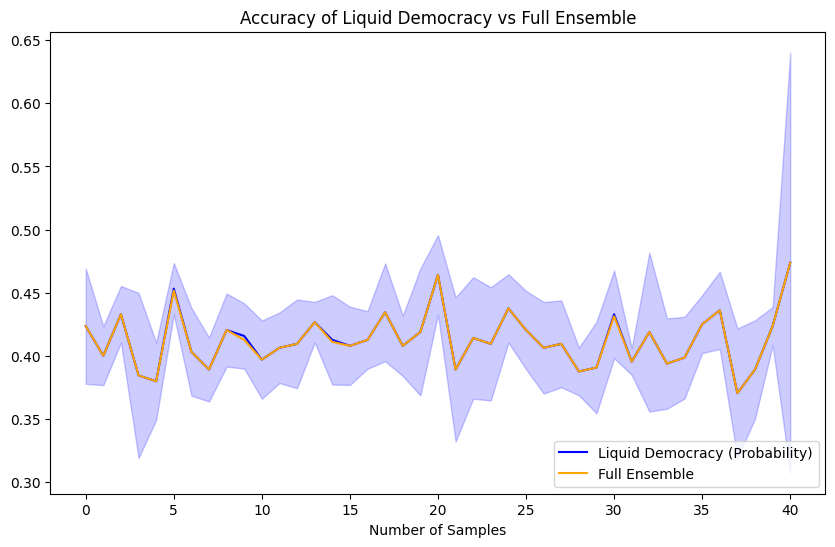

In [71]:
# plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Accuracy of Liquid Democracy vs Full Ensemble")
ax.set_xlabel("Number of Samples")

ax.plot(
    range(len(ld_proba_accs)),
    ld_proba_accs,
    label="Liquid Democracy (Probability)",
    color="blue",
)
ax.fill_between(
    range(len(ld_proba_accs)),
    ld_proba_accs - ld_proba_CIs,
    ld_proba_accs + ld_proba_CIs,
    alpha=0.2,
    color="blue",
)

ax.plot(
    range(len(full_ensemble_accs)),
    full_ensemble_accs,
    label="Full Ensemble",
    color="orange",
)

# plot legend
ax.legend(loc="lower right")

# plot the results
plt.show()

In [104]:
import numpy as np
from scipy.stats import linregress

# Your data points
data_points = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]

# Creating an array for the positions (1, 2, 3, ...)
positions = np.arange(1, len(data_points) + 1)

# Applying linear regression
slope, intercept, r_value, p_value, std_err = linregress(positions, data_points)

# The slope is the trend estimation
slope

0.0

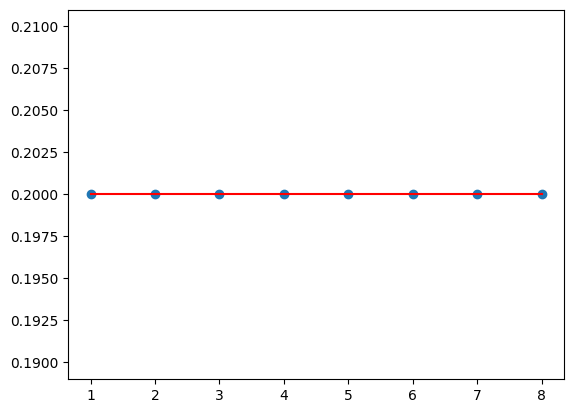

In [105]:
# plot
plt.plot(positions, data_points, 'o', label='original data')
#plot the trend line
plt.plot(positions, intercept + slope*positions, 'r', label='fitted line')